In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=52bc2c3cd49c63feaf7627fe907c59f840e31efc070aa5dbbba3d09d039a8359
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

# Any results you write to the current directory are saved as output.

**BUILD DATASET**

In [3]:
dataset_path = './dataset'

In [4]:
samples = 25

In [5]:
covid_dataset_path = '../input/covid-chest-xray'

In [6]:

%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal



In [7]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

**BUILD NORMAL XRAY DATASET**

In [8]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [9]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

**PLOT THE XRAYs**

In [10]:
#helper functions to plot them in a grid
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [11]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

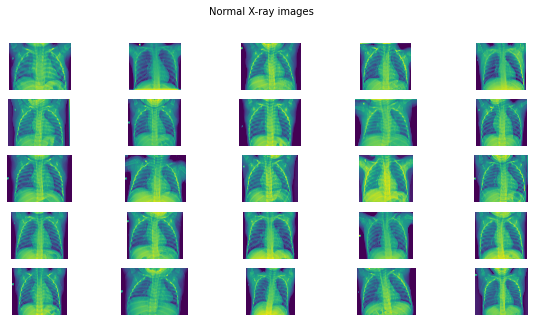

In [12]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

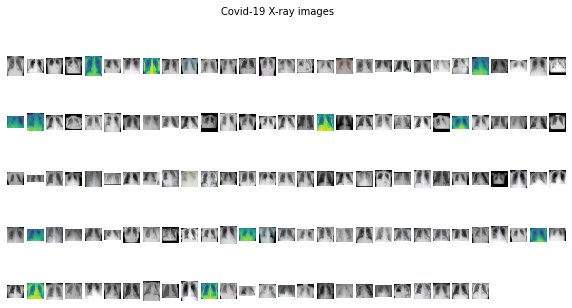

In [13]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

**DATA PREPROCESSING**

In [14]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [15]:
# perform one-hot encoding on the labels
lb = label_binarize(labels, classes=['covid','normal'])
#labels = lb.fit_transform(labels)
labels = to_categorical(lb)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

**DEFINING THE MODEL**

In [16]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 20
BS = 8

In [17]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


**TRAINING**

In [18]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
validation_steps=len(testX) // BS,
epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Train for 16 steps, validate on 34 samples
Epoch 1/20
16/16 [==============================] - 30s 2s/step - loss: 0.8621 - accuracy: 0.6290 - val_loss: 0.3993 - val_accuracy: 0.8750
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 0.5296 - accuracy: 0.8306 - val_loss: 0.3261 - val_accuracy: 0.8750
Epoch 3/20
16/16 [==============================] - 28s 2s/step - loss: 0.4266 - accuracy: 0.8468 - val_loss: 0.2689 - val_accuracy: 0.8750
Epoch 4/20
16/16 [==============================] - 29s 2s/step - loss: 0.3503 - accuracy: 0.8548 - val_loss: 0.2378 - val_accuracy: 0.8750
Epoch 5/20
16/16 [==============================] - 28s 2s/step - loss: 0.3108 - accuracy: 0.8548 - val_loss: 0.2105 - val_accuracy: 0.8750
Epoch 6/20
16/16 [==============================] - 29s 2s/step - loss: 0.3270 - accuracy: 0.8710 - val_loss: 0.1855 - val_accuracy: 0.8750
Epoch 7/20
16/16 [==============================] - 28s 2s/step - l

**PLOT TRAINING METRICS**

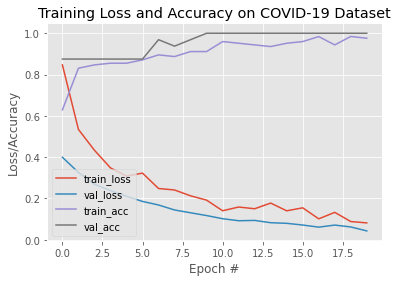

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Part2: Analyzing each individual XRAYs****

in this section two tasks have been performed in an attempt to compare a normal chest XRAY with that of COVID19 chest XRAY at a little more deeper level
1. image clustering: to cluster the xrays into optimal level of clusters
    a. maybe, this culd help us create masks, which can be used in semantic segmentation tasks(supervised approach)
    b. one common features of a covid19 xray is ground glass opacity, the reason why i chose unsupervised clustering approach is to differentiate the opaque part of the chest from the normal part. This          might help us in determining if the person might need a ventilator in near future.
2. bit plane slicing: this is a technique that is normally used in image compression. but this simple method might help us in detecting the edges and boundaries. this information might be useful             when compared with normal xray 
   
   
for testing purposes, i tried both the tasks on a sample image. but thais can be done on all the images
    


for clustering, optimal value of clusters (k) has to be determined. this has been done using the elbow method

In [20]:
#k_opt gives the optimal value of k.
def find_optimal_k(img):
    image = cv2.imread(img)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,20) 
    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(pixel_values) 
        kmeanModel.fit(pixel_values) 
        distortions.append(sum(np.min(cdist(pixel_values, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / pixel_values.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
        mapping1[k] = sum(np.min(cdist(pixel_values, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / pixel_values.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 
        #find the optimal value of k
        # the approximate value of k is where the dip occurs
        #here, i have taken the dip to occur at that point where the distortion values start to vary by <=2 points
    for i in K:
        if(mapping1[i] - mapping1[i+1]) <=2:
            k_opt = i
            break
    for key,val in mapping1.items(): 
        print(str(key)+' : '+str(val))
        
       
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.title('The Elbow Method using Distortion') 
    plt.show()
    
    return k_opt


visualize clusters vs distortions. the optimal value of k occurs approximately at the dip

kmeans method

In [21]:
def kmeans_seg(img,k_opt):
    image = cv2.imread(img)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    print(pixel_values.shape)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = k_opt
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers1 = np.uint8(centers)
    # flatten the labels array
    labels1 = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers1[labels1.flatten()]
    # reshape back to the original image dimension
    segmented_image1 = segmented_image.reshape(image.shape)
    # show the image
    plt.title('clustered xray') 
    plt.imshow(segmented_image1)
    plt.show()
    plt.title('original xray') 
    plt.imshow(image)
    plt.show()
    

testing it on a sample image

clustering on covid19 xray

In [ ]:
k_opt = find_optimal_k(covid_images[1])
kmeans_seg(covid_images[1],k_opt)


clustering on normal xray

In [ ]:
k_opt1 = find_optimal_k(normal_images[1])
kmeans_seg(normal_images[1],k_opt1)


In [ ]:
def bit_plane_slicing(img):
    #read the image in grayscale
    image = cv2.imread(img,0)
    lst = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            lst.append(np.binary_repr(image[i][j] ,width=8)) # width = no. of bits
    
    # We have a list of strings where each string represents binary pixel value. To extract bit planes we need to iterate over the strings and store the characters corresponding to bit planes into lists.
    # Multiply with 2^(n-1) and reshape to reconstruct the bit image.
    eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(image.shape[0],image.shape[1])
    seven_bit_img = (np.array([int(i[1]) for i in lst],dtype = np.uint8) * 64).reshape(image.shape[0],image.shape[1])
    six_bit_img = (np.array([int(i[2]) for i in lst],dtype = np.uint8) * 32).reshape(image.shape[0],image.shape[1])
    five_bit_img = (np.array([int(i[3]) for i in lst],dtype = np.uint8) * 16).reshape(image.shape[0],image.shape[1])
    four_bit_img = (np.array([int(i[4]) for i in lst],dtype = np.uint8) * 8).reshape(image.shape[0],image.shape[1])
    three_bit_img = (np.array([int(i[5]) for i in lst],dtype = np.uint8) * 4).reshape(image.shape[0],image.shape[1])
    two_bit_img = (np.array([int(i[6]) for i in lst],dtype = np.uint8) * 2).reshape(image.shape[0],image.shape[1])
    one_bit_img = (np.array([int(i[7]) for i in lst],dtype = np.uint8) * 1).reshape(image.shape[0],image.shape[1])
    
    fig = plt.figure(figsize = (16,8))
    fig,a =  plt.subplots(2,4)
    fig. tight_layout(pad=50)
    
    a[0][0].imshow(eight_bit_img)
    a[0][0].set_title('eight bit slice')
    a[0][1].imshow(seven_bit_img)
    a[0][1].set_title('seven bit slice')
    a[0][2].imshow(six_bit_img)
    a[0][2].set_title('six bit slice')
    a[0][3].imshow(five_bit_img)
    a[0][3].set_title('five bit slice')
    a[1][0].imshow(four_bit_img)
    a[1][0].set_title('four bit slice') 
    a[1][1].imshow(three_bit_img)
    a[1][1].set_title('three bit slice') 
    a[1][2].imshow(two_bit_img)
    a[1][2].set_title('two bit slice')
    a[1][3].imshow(one_bit_img)
    a[1][3].set_title('one bit slice') 
    
   
    
    

testing it on a sample image

bit plane slicing of covid19 xrays

In [ ]:
bit_plane_slicing(covid_images[1])

In [ ]:
bit_plane_slicing(normal_images[1])